# Import Libraries 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# LOAD DATA

In [2]:
books = pd.read_csv ('Books.csv')

# Data Preprocessing

In [3]:
# Clean column names and whitespace
books.columns = books.columns.str.strip()

# Remove spaces in object columns
for col in books.select_dtypes(include=["object"]).columns:
    books[col] = books[col].replace(r'\s+', ' ', regex=True)

In [4]:
# Fix column names according to your dataset
books.rename(columns={'published': 'published_year', 'average_r': 'average_rating', 'num_page': 'num_pages'}, inplace=True)

In [5]:
# Handle Missing Data
print("Missing values before handling:")
books.isnull().sum()

Missing values before handling:


isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
dtype: int64

In [6]:
books.shape

(6810, 12)

In [ ]:
# Drop columns with too many missing values or low importance
books = books.drop(columns=['subtitle', 'description'])

# Impute missing values with a placeholder
books['authors'] = books['authors'].fillna('Unknown')
books['thumbnail'] = books['thumbnail'].fillna('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOAp5VXoGKS16VrxT0PuDgPsktnBnT614axA&s')
books['categories'] = books['categories'].fillna('Unknown')

# Impute missing values for 'average_rating' with median
books['average_rating'] = books['average_rating'].fillna(books['average_rating'].median())

# Impute missing values for 'ratings_count' with 0
books['ratings_count'] = books['ratings_count'].fillna(0)

# dropna missing values with median
books.dropna(subset=['num_pages' , 'published_year'], inplace=True)
books.reset_index(drop=True, inplace=True)

print("After Handling:")
print(books.isnull().sum())


After Handling:
isbn13            0
isbn10            0
title             0
authors           0
categories        0
thumbnail         0
published_year    0
average_rating    0
num_pages         0
ratings_count     0
dtype: int64


In [8]:
books.shape

(6762, 10)

In [9]:
# Select essential columns
books = books[['title', 'authors', 'categories', 'average_rating', 'ratings_count', 'num_pages', 'published_year', 'thumbnail']]

In [10]:
# === 4. FEATURE ENGINEERING ===
books['tags'] = books['title'] + ' ' + books['authors'] + ' ' + books['categories']
books['tags'] = books['tags'].str.lower()

# Data Visualization

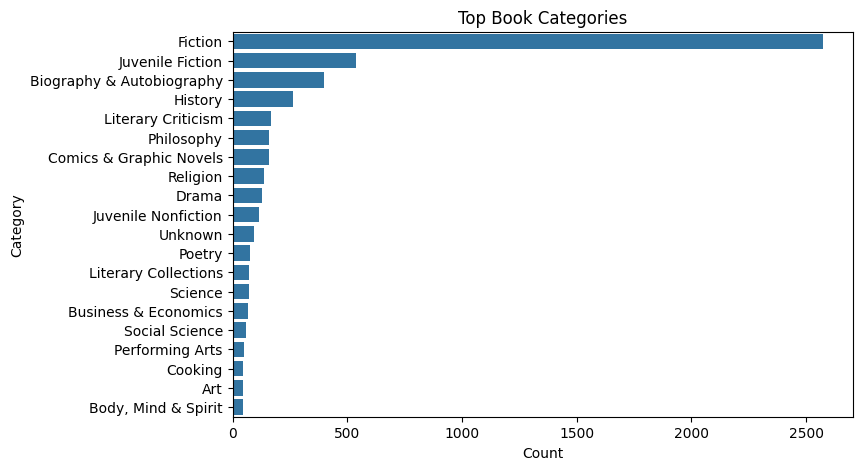

In [25]:
# Top categories
top_categories = pd.Series(";".join(books['categories']).split(';')).value_counts().head(20)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top Book Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

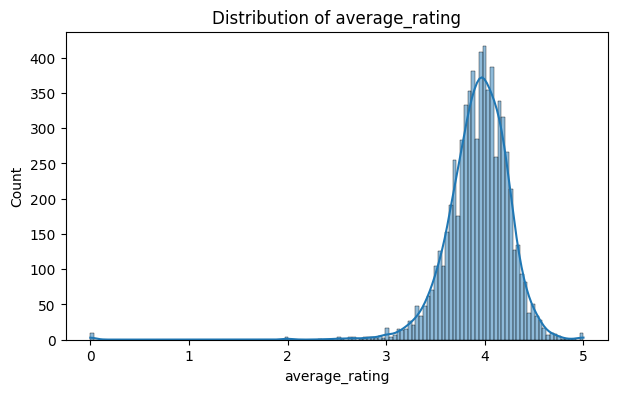

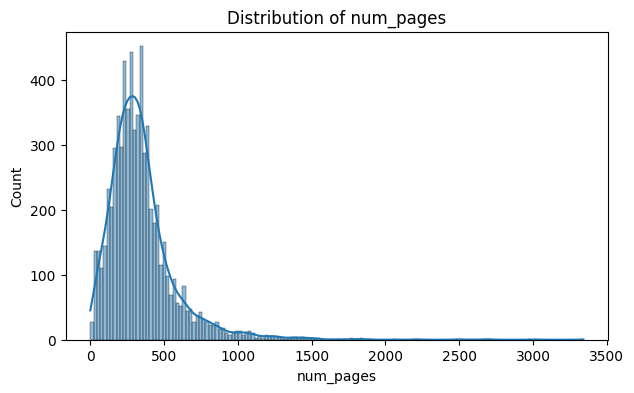

In [27]:
# Numeric distributions
for col in ['average_rating', 'num_pages']:
    plt.figure(figsize=(7, 4))
    sns.histplot(books[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

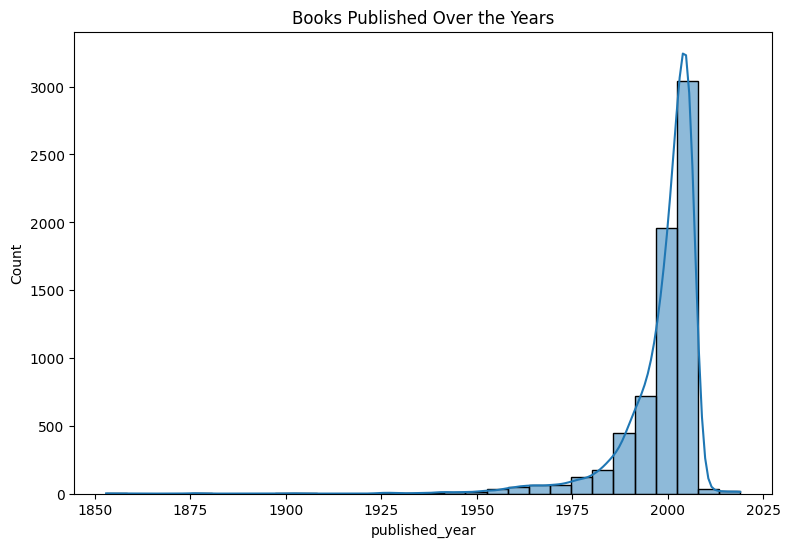

In [29]:
# Published year
plt.figure(figsize=(9, 6))
sns.histplot(books['published_year'], bins=30, kde=True)
plt.title('Books Published Over the Years')
plt.show()

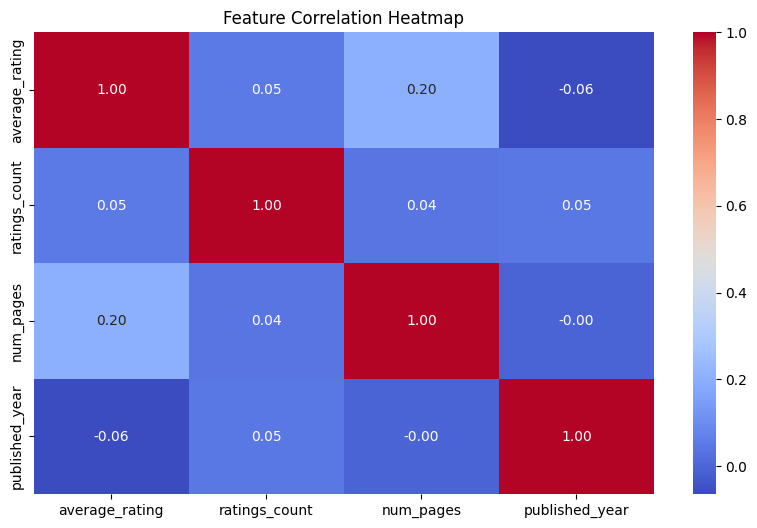

In [14]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(books[['average_rating', 'ratings_count', 'num_pages', 'published_year']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# RECOMMENDATION FUNCTIONS

In [15]:
ps = PorterStemmer()

def stem_text(text):
    return " ".join([ps.stem(word) for word in text.split()])

books['tags'] = books['tags'].apply(stem_text)

# VECTORIZATION
cv = CountVectorizer(max_features=5000, stop_words='english')
vector = cv.fit_transform(books['tags']).toarray()

# SIMILARITY MATRIX
similarity = cosine_similarity(vector)

## Recommendation by Book Title using similarity matrix 

In [16]:
def recommend(book_title):
    try:
        # Find the index of the book in the DataFrame
        index = books[books['title'].str.lower() == book_title.lower()].index[0]
    except IndexError:
        print(f"Book titled '{book_title}' not found.")
        return pd.DataFrame()

    # Get similarity scores for the book with all others
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    
    # Collect top 5 recommendations excluding the book itself
    recommended_indices = [i[0] for i in distances[1:6]]
    recommended_books = books.iloc[recommended_indices]
    
    return recommended_books

## Recommendation by Category

In [17]:
def recommend_by_category(category_name, top_n=5):
    # Filter books containing the category (case-insensitive)
    category_books = books[books['categories'].str.contains(category_name, case=False, na=False)].copy()
    
    if category_books.empty:
        print(f"No books found in category '{category_name}'.")
        return pd.DataFrame()

    # Create a score combining average rating and number of ratings (popularity * quality)
    category_books['score'] = category_books['average_rating'] * category_books['ratings_count']
    
    # Sort by score descending and return top_n
    top_books = category_books.sort_values(by='score', ascending=False).head(top_n)
    
    return top_books

### Examples

In [18]:

# Example: Recommend books similar to a given title
print("Recommendations based on book title:")
recommended = recommend("Hannibal")
if not recommended.empty:
    display(recommended[['title', 'authors', 'categories', 'average_rating']])
else:
    print("No recommendations found.")

# Example: Recommend top books in a category
print("\nTop books in category 'Fantasy':")
top_category_books = recommend_by_category("Fantasy", top_n=5)
if not top_category_books.empty:
    display(top_category_books[['title', 'authors', 'categories', 'average_rating', 'ratings_count']])
else:
    print("No books found in this category.")


Recommendations based on book title:


,title,authors,categories,average_rating
5527,The Alienist,Machado de Assis,Mental illness,4.05
2636,The Hannibal Lecter Trilogy,Thomas Harris,"Lecter, Hannibal (Fictitious character)",4.42
2995,Black Sunday,Thomas Harris,Fiction,3.60
6510,Red Dragon,Thomas Harris,Adventure stories,4.48
917,One Flew Over the Cuckoo's Nest,Ken Kesey,Mentally ill,4.19



Top books in category 'Fantasy':


,title,authors,categories,average_rating,ratings_count
1765,The Fellowship of the Ring,John Ronald Reuel Tolkien,Fantasy fiction,4.52,532629.0
22,The Mad Ship,Robin Hobb,Fantasy fiction,4.24,36101.0
6540,Magic Kingdom for Sale,Terry Brooks,Fantasy fiction,3.88,29300.0
3622,Servant of the Empire,Raymond E. Feist;Janny Wurts,Fantasy,4.29,22247.0
6532,The Magician's Assistant,Ann Patchett,Fantasy fiction,3.65,24470.0
